In [1]:
import os
import random
import pickle
from tqdm import tqdm

import numpy as np
from PIL import Image, ImageDraw

In [2]:
dino_cpkt_path = '/workspace/traffic_light/mmdetection/outputs_result/4_epoch_dino_swin.pkl'
test_image_path = "/workspace/traffic_light/data/detection/test/images"

In [3]:
categories = [
    "veh_go",
    "veh_goLeft",
    "veh_noSign",
    "veh_stop",
    "veh_stopLeft",
    "veh_stopWarning",
    "veh_warning",
    "ped_go",
    "ped_noSign",
    "ped_stop",
    "bus_go",
    "bus_noSign",
    "bus_stop",
    "bus_warning",
]
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

# visualization
- ref : https://huggingface.co/docs/transformers/tasks/object_detection

10005936.jpg
25


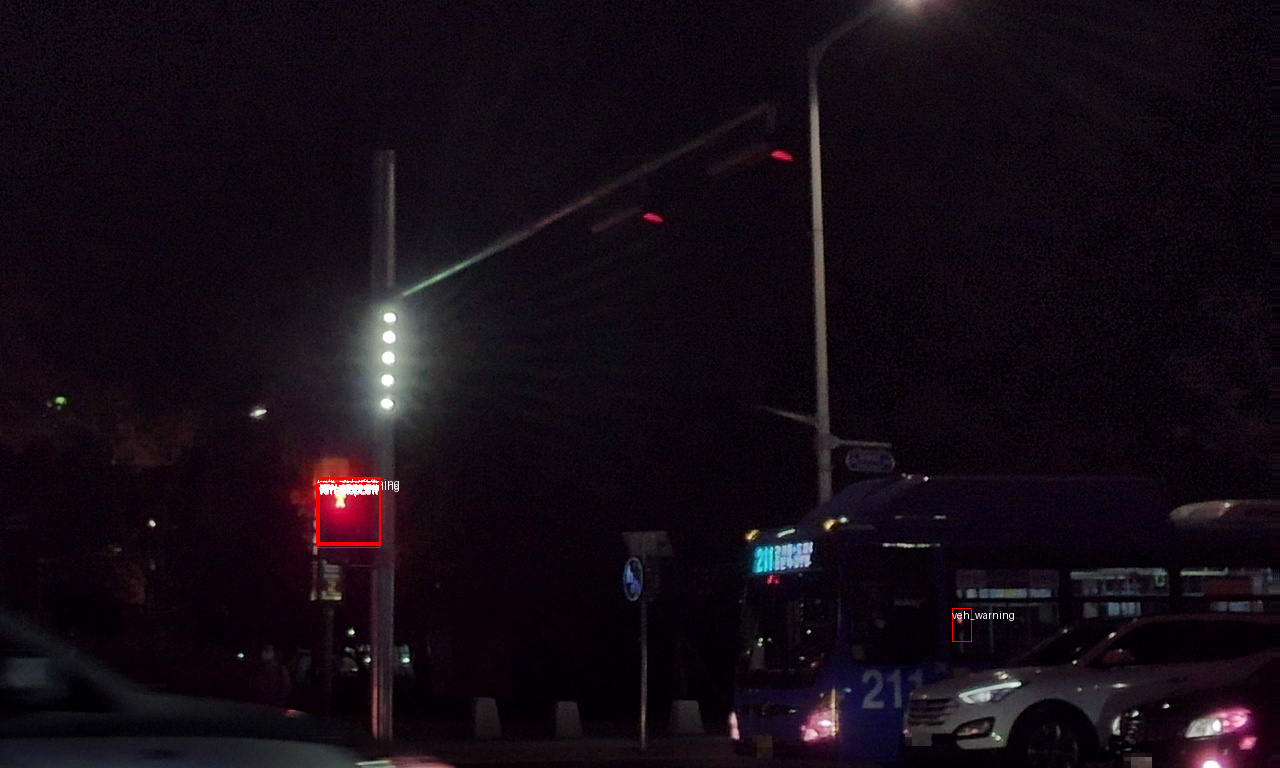

In [4]:
test_annos = os.listdir(test_image_path)
random_num = random.randrange(10004956, 10006688)
# random_num = random.randrange(10000000, 10000000 + len(test_annos))
# random_num = '10006229'

sample_img = os.path.join(test_image_path, f"{random_num}.jpg")
print(os.path.basename(sample_img))

img = Image.open(sample_img)
original_w, original_h = img.size
# print(original_w, original_h)
draw = ImageDraw.Draw(img)


with open(dino_cpkt_path, 'rb') as f:
    datas = pickle.load(f)
    
    for data in datas:
        if data['img_id'] != int(random_num):
            continue
        cnt =0
        # img_path = data['img_path']
        for score, bbox, label in zip(data['pred_instances']['scores'], data['pred_instances']['bboxes'], data['pred_instances']['labels']):
            score = score.numpy()
            label = label.item()
            x_min, y_min, x_max, y_max  = bbox.numpy()

            if y_max > original_h:
                print(x_min, y_min, x_max, y_max)

            if score < 0.014:  # ! score 조정하기!
                continue 
            cnt +=1
            
            draw.rectangle((x_min, y_min, x_max, y_max), outline="red", width=1)
            draw.text((x_min, y_min), id2label[label], fill="white")
        print(cnt)
        break

img

In [9]:
def nms(bounding_boxes, confidence_score, labels, threshold):
    """
    ref: https://github.com/amusi/Non-Maximum-Suppression/blob/master/nms.py
    the boxes format is xyxy
    e.g) 
    bounding_boxes = [(187, 82, 337, 317), (150, 67, 305, 282), (246, 121, 368, 304)]
    confidence_score = [0.9, 0.75, 0.8]
    threshold = 0.4
    """
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []
    picked_labels = []
    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])
        picked_labels.append(labels[index])
        
        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score, picked_labels

In [10]:
def xyxy2xywhn(bbox, w, h):
    x_min, y_min, x_max, y_max  = bbox
    
    if x_max > w:
        x_max = float(w)

    if x_min < 0:
        x_min = float(0)

    if y_max > h:
        y_max = float(h)

    if y_min < 0:
        y_min = float(0)

    norm_w = np.abs(x_max-x_min)/w
    norm_h = np.abs(y_max-y_min)/h
    norm_center_x = (x_max+x_min)/(2*w)
    norm_center_y = (y_max+y_min)/(2*h)
    return (norm_center_x, norm_center_y, norm_w, norm_h)

In [13]:
# APPLY NMS
output_label_path="/workspace/traffic_light/submission/wbf_v5_yolo_dino_co/4_epoch_dino_swin_nms(0.1)_score(0.014)"

nms_iou_threshold=0.1
score_threshold=0.014
empty_file_cnt=0
os.makedirs(output_label_path, exist_ok=True)
with open(dino_cpkt_path, 'rb') as f:
    labels=pickle.load(f)
    # print(len(labels))
    for label in tqdm(labels):
        lines=[]
        file_num = label['img_id']
        original_h, original_w = label['ori_shape']
        picked_boxes, picked_score, picked_categories = nms(label['pred_instances']['bboxes'], 
                                         label['pred_instances']['scores'],
                                         label['pred_instances']['labels'], 
                                         nms_iou_threshold)
        
        for bbox, score, category in zip(picked_boxes, picked_score, picked_categories):
            if score < score_threshold:  # ! score 조정하기!
                continue
            category = category.item()
            x_min, y_min, x_max, y_max  = bbox.numpy()
            norm_center_x, norm_center_y, norm_w, norm_h  = xyxy2xywhn((x_min, y_min, x_max, y_max), original_w, original_h)
            lines.append((category, norm_center_x, norm_center_y, norm_w, norm_h, score))
        
        if not lines:
            empty_file_cnt+=1
            print(f'{file_num}.txt')
        
        with open(os.path.join(output_label_path, f'{file_num}.txt'), 'w') as file:
            for line in lines:
                category, norm_center_x, norm_center_y, norm_w, norm_h, score = line
                file.write("%d %lf %lf %lf %lf %lf\n"
                % (category, norm_center_x, norm_center_y, norm_w, norm_h, score))      

print("no box files: ", empty_file_cnt)
print("done")

 41%|████      | 5543/13505 [00:04<00:05, 1464.10it/s]

10005288.txt


100%|██████████| 13505/13505 [00:11<00:00, 1156.36it/s]

no box files:  1
done


In [12]:
# output_label_path = "/workspace/traffic_light/submission/cascade_convnext_epoch_5"
# empty_file_cnt=0
# os.makedirs(output_label_path, exist_ok=True)
# with open(dino_cpkt_path, 'rb') as f:
#     labels=pickle.load(f)
#     print(len(labels))
#     for label in tqdm(labels):
#         lines=[]
#         file_num = label['img_id']
#         original_h, original_w = label['ori_shape']
#         # print(original_w, original_h)
#         for score, bbox, category in zip(label['pred_instances']['scores'], label['pred_instances']['bboxes'], label['pred_instances']['labels']):
#             score = score.numpy()
#             if score < 0.1:  # ! score 조정하기!
#                 continue
#             category = category.item()
#             x_min, y_min, x_max, y_max  = bbox.numpy()
#             norm_center_x, norm_center_y, norm_w, norm_h  = xyxy2xywhn((x_min, y_min, x_max, y_max), original_w, original_h)
#             lines.append((category, norm_center_x, norm_center_y, norm_w, norm_h, score))
#         if not lines:
#             print(file_num)
#             empty_file_cnt+=1
#         # with open(os.path.join(output_label_path, f'{file_num}.txt'), 'w') as file:
#         #     for line in lines:
#         #         category, norm_center_x, norm_center_y, norm_w, norm_h, score = line
#         #         file.write("%d %lf %lf %lf %lf %lf\n"
#         #         % (category, norm_center_x, norm_center_y, norm_w, norm_h, score))      
# # print(file_list)
# print("no box files: ", empty_file_cnt)
# print("done")

In [ ]:
# AUG_cascade-convnext_2 5epoch - no box files : 481 (no thres 350)
# AUG_cascade-convnext 2epoch - no box files : 561 (no thres 390)
# AUG_cascade-convnext 5epoch - no box files : 477 (score threshold 0.1) , 343 (no threshold)
# AUG_cascade-convnext 20epoch - no box files : 793 (no thres 659)
# NO_AUG_dino_swin_2epoch - no box files : 6
# NO_AUG_dino_swin_4epoch - no box files : 65